# Data Engineering

## Import

In [ ]:
import os
import numpy as np
import cv2
from zipfile import ZipFile
import shutil
from sklearn.model_selection import train_test_split

## Data

load data function

In [ ]:
# 폴더로부터 이미지를 불러온다.
def image_load(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        if img is not None:
            images.append(img)
            if "climb" == label:
                labels.append(1)
            else:
                labels.append(0)
    return images, labels

True(Climb)

In [ ]:
climb_images, climb_labels = image_load("/content/drive/MyDrive/BabyProject/CV_img_data/True/true_set", "climb")

False(not Climb)

In [ ]:
not_climb_images, not_climb_labels = image_load("/content/drive/MyDrive/BabyProject/datas/fasle", "not climb")

In [ ]:
# climb 데이터와 not climb 데이터를 합치기
images = climb_images + not_climb_images
labels = climb_labels + not_climb_labels

In [ ]:
import cv2

def resize_images(images, target_size=(224, 224)):
    resized_images = []
    for img in images:
        resized_img = cv2.resize(img, target_size)
        resized_images.append(resized_img)
    return np.array(resized_images)

# 이미지 크기 조정
resized_images = resize_images(images)

# NumPy 배열로 변환
labels = np.array(labels)

# 데이터셋 분할 (훈련용:검증용:테스트용 = 0.7:0.15:0.15)
train_images, test_images, train_labels, test_labels = train_test_split(resized_images, labels, test_size=0.3, random_state=42)
val_images, test_images, val_labels, test_labels = train_test_split(test_images, test_labels, test_size=0.5, random_state=42)

# 데이터셋 크기 확인
print("훈련용 데이터셋 크기:", train_images.shape)
print("검증용 데이터셋 크기:", val_images.shape)
print("테스트용 데이터셋 크기:", test_images.shape)

훈련용 데이터셋 크기: (651, 224, 224, 3)
검증용 데이터셋 크기: (139, 224, 224, 3)
테스트용 데이터셋 크기: (140, 224, 224, 3)


# Preprocessing

기본 전처리

In [ ]:
from keras.applications.vgg16 import preprocess_input

# 이미지 크기 조정
def resize_images(images, size=(224, 224)):
    resized_images = []
    for image in images:
        resized_image = cv2.resize(image, size)
        resized_images.append(resized_image)
    return np.array(resized_images)

# 이미지 전처리 함수 정의
def preprocess_images(images):
    # 이미지 크기 조정
    resized_images = resize_images(images)
    # VGG16 모델에 맞게 입력 이미지 전처리
    preprocessed_images = preprocess_input(resized_images)
    return preprocessed_images

# 이미지 전처리
train_images_preprocessed = preprocess_images(train_images)
val_images_preprocessed = preprocess_images(val_images)
test_images_preprocessed = preprocess_images(test_images)

# Model

## Import

In [ ]:
import torch
torch.cuda.is_available()

True

In [ ]:
!nvidia-smi

Fri May 17 09:20:46 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8              10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
from keras.applications import VGG16
from keras.models import Model
from keras.layers import Dense, Flatten
from keras.optimizers import Adam

In [ ]:

# VGG16 모델 불러오기
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 새로운 분류층 추가
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

# 전체 모델 정의
model = Model(inputs=base_model.input, outputs=predictions)

# VGG16의 가중치는 고정시키고 새로 추가한 층만 훈련
for layer in base_model.layers:
    layer.trainable = False

# 모델 컴파일
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# 모델 훈련
history = model.fit(train_images_preprocessed, train_labels, batch_size=32, epochs=10, validation_data=(val_images_preprocessed, val_labels))

# 모델 평가
loss, accuracy = model.evaluate(test_images_preprocessed, test_labels)
print("테스트 데이터셋에서의 손실:", loss)
print("테스트 데이터셋에서의 정확도:", accuracy)


58889256/58889256 [==============================] - 3s 0us/step
Epoch 1/10
21/21 [==============================] - 16s 316ms/step - loss: 1.3146 - accuracy: 0.9462 - val_loss: 0.6028 - val_accuracy: 0.9928
Epoch 2/10
21/21 [==============================] - 3s 147ms/step - loss: 0.1365 - accuracy: 0.9969 - val_loss: 0.3395 - val_accuracy: 0.9928
Epoch 3/10
21/21 [==============================] - 3s 155ms/step - loss: 8.9475e-12 - accuracy: 1.0000 - val_loss: 0.2151 - val_accuracy: 0.9928
Epoch 4/10
21/21 [==============================] - 3s 153ms/step - loss: 2.2389e-04 - accuracy: 1.0000 - val_loss: 0.4223 - val_accuracy: 0.9928
Epoch 5/10
21/21 [==============================] - 3s 152ms/step - loss: 1.4619e-16 - accuracy: 1.0000 - val_loss: 0.6527 - val_accuracy: 0.9928
Epoch 6/10
21/21 [==============================] - 3s 153ms/step - loss: 6.7039e-15 - accuracy: 1.0000 - val_loss: 0.6802 - val_accuracy: 0.9928
Epoch 7/10
21/21 [==============================] - 3s 153ms/step 

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# 모델 예측
predictions = model.predict(test_images_preprocessed)
# 확률을 이진 클래스로 변환
predictions_binary = np.where(predictions > 0.5, 1, 0)

# 정밀도, 재현율, F1 스코어 계산
precision = precision_score(test_labels, predictions_binary)
recall = recall_score(test_labels, predictions_binary)
f1 = f1_score(test_labels, predictions_binary)

print("정밀도:", precision)
print("재현율:", recall)
print("F1 스코어:", f1)


5/5 [==============================] - 1s 134ms/step
정밀도: 0.9857142857142858
재현율: 0.971830985915493
F1 스코어: 0.9787234042553192


#Sec Model

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# 모델 생성
model = Sequential()

# Convolutional Layer와 Pooling Layer 추가
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Fully Connected Layer 추가
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# 모델 컴파일
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 모델 구조 출력
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 54, 54, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 26, 26, 128)      

In [ ]:
# 모델 훈련
history = model.fit(train_images_preprocessed, train_labels, batch_size=32, epochs=10, validation_data=(val_images_preprocessed, val_labels))

# 모델 평가
loss, accuracy = model.evaluate(test_images_preprocessed, test_labels)
print("테스트 데이터셋에서의 손실:", loss)
print("테스트 데이터셋에서의 정확도:", accuracy)


Epoch 1/10
21/21 [==============================] - 6s 110ms/step - loss: 29.4494 - accuracy: 0.7327 - val_loss: 0.4604 - val_accuracy: 0.8201
Epoch 2/10
21/21 [==============================] - 1s 70ms/step - loss: 0.3116 - accuracy: 0.8817 - val_loss: 0.3147 - val_accuracy: 0.8273
Epoch 3/10
21/21 [==============================] - 1s 68ms/step - loss: 0.1456 - accuracy: 0.9508 - val_loss: 0.2305 - val_accuracy: 0.8921
Epoch 4/10
21/21 [==============================] - 1s 71ms/step - loss: 0.0590 - accuracy: 0.9785 - val_loss: 0.3612 - val_accuracy: 0.8993
Epoch 5/10
21/21 [==============================] - 1s 69ms/step - loss: 0.0779 - accuracy: 0.9800 - val_loss: 1.4922 - val_accuracy: 0.7050
Epoch 6/10
21/21 [==============================] - 2s 79ms/step - loss: 0.1736 - accuracy: 0.9462 - val_loss: 0.3268 - val_accuracy: 0.8633
Epoch 7/10
21/21 [==============================] - 2s 80ms/step - loss: 0.0721 - accuracy: 0.9739 - val_loss: 0.1112 - val_accuracy: 0.9496
Epoch 8/10


Canny Edge

In [ ]:

def preprocess_images_with_edge_detection(images):
    preprocessed_images = []
    for image in images:
        # 이미지를 흑백으로 변환
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # Canny 에지 검출을 통해 에지 감지
        edges = cv2.Canny(gray, threshold1=30, threshold2=100)
        # 에지 이미지를 원본 이미지와 결합하여 새로운 이미지 생성
        edge_image = np.dstack([edges] * 3)
        preprocessed_images.append(edge_image)
    return np.array(preprocessed_images)

# 이미지 전처리
train_images_preprocessed_with_edge = preprocess_images_with_edge_detection(train_images)
val_images_preprocessed_with_edge = preprocess_images_with_edge_detection(val_images)
test_images_preprocessed_with_edge = preprocess_images_with_edge_detection(test_images)


In [ ]:
# 모델 생성
model = Sequential()

# Convolutional Layer와 Pooling Layer 추가
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Fully Connected Layer 추가
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# 모델 컴파일
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 모델 훈련
history = model.fit(train_images_preprocessed_with_edge, train_labels, batch_size=32, epochs=50, validation_data=(val_images_preprocessed_with_edge, val_labels))

# 모델 평가
loss, accuracy = model.evaluate(test_images_preprocessed_with_edge, test_labels)
print("테스트 데이터셋에서의 손실:", loss)
print("테스트 데이터셋에서의 정확도:", accuracy)

# 예측 수행
predictions = model.predict(test_images)
predictions = (predictions > 0.55).astype(int)  # 임계값 0.6 적용

# F1 스코어 계산
f1 = f1_score(test_labels, predictions)
print("테스트 데이터셋에서의 F1 스코어:", f1)

Epoch 1/50
21/21 [==============================] - 4s 68ms/step - loss: 272.1466 - accuracy: 0.6344 - val_loss: 0.4115 - val_accuracy: 0.8273
Epoch 2/50
21/21 [==============================] - 1s 53ms/step - loss: 0.2787 - accuracy: 0.9078 - val_loss: 0.2841 - val_accuracy: 0.8777
Epoch 3/50
21/21 [==============================] - 1s 52ms/step - loss: 0.0967 - accuracy: 0.9754 - val_loss: 0.2779 - val_accuracy: 0.9065
Epoch 4/50
21/21 [==============================] - 1s 49ms/step - loss: 0.0416 - accuracy: 0.9877 - val_loss: 0.2729 - val_accuracy: 0.9065
Epoch 5/50
21/21 [==============================] - 1s 49ms/step - loss: 0.0224 - accuracy: 1.0000 - val_loss: 0.2830 - val_accuracy: 0.9137
Epoch 6/50
21/21 [==============================] - 1s 49ms/step - loss: 0.0245 - accuracy: 0.9939 - val_loss: 0.3444 - val_accuracy: 0.8993
Epoch 7/50
21/21 [==============================] - 1s 49ms/step - loss: 0.0237 - accuracy: 0.9939 - val_loss: 0.4401 - val_accuracy: 0.8993
Epoch 8/50


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# 모델 예측
predictions = model.predict(test_images_preprocessed_with_edge)
# 확률을 이진 클래스로 변환
predictions_binary = np.where(predictions > 0.55, 1, 0)

# 정밀도, 재현율, F1 스코어 계산
precision = precision_score(test_labels, predictions_binary)
recall = recall_score(test_labels, predictions_binary)
f1 = f1_score(test_labels, predictions_binary)

print("정밀도:", precision)
print("재현율:", recall)
print("F1 스코어:", f1)


5/5 [==============================] - 0s 15ms/step
정밀도: 0.9545454545454546
재현율: 0.8873239436619719
F1 스코어: 0.9197080291970803


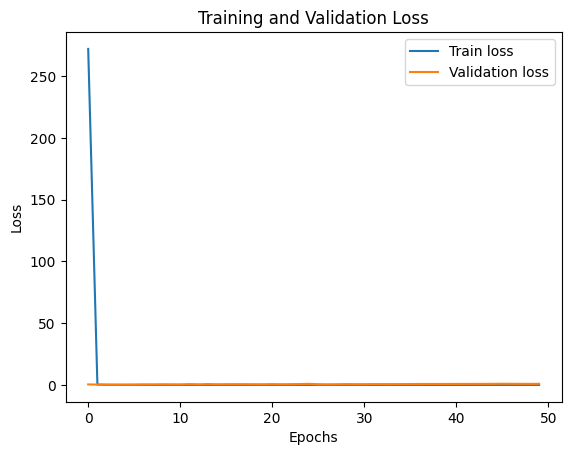

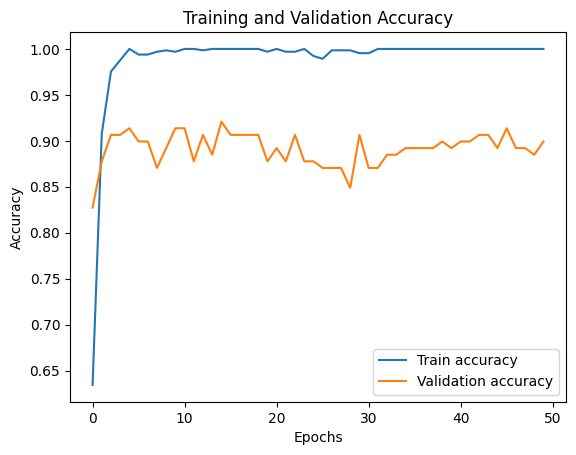

In [ ]:
import matplotlib.pyplot as plt

# 훈련 및 검증 손실 시각화
def plot_loss(history):
    plt.plot(history.history['loss'], label='Train loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# 훈련 및 검증 정확도 시각화
def plot_accuracy(history):
    plt.plot(history.history['accuracy'], label='Train accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# 모델 훈련 후 시각화
plot_loss(history)
plot_accuracy(history)


In [ ]:
# VGG16 모델 불러오기
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 새로운 분류층 추가
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

# 전체 모델 정의
model = Model(inputs=base_model.input, outputs=predictions)

# VGG16의 가중치는 고정시키고 새로 추가한 층만 훈련
for layer in base_model.layers:
    layer.trainable = False

# 모델 컴파일
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# 모델 훈련
history = model.fit(train_images_preprocessed, train_labels, batch_size=32, epochs=10, validation_data=(val_images_preprocessed, val_labels))

# 모델 평가
loss, accuracy = model.evaluate(test_images_preprocessed, test_labels)
print("테스트 데이터셋에서의 손실:", loss)
print("테스트 데이터셋에서의 정확도:", accuracy)


Epoch 1/10
21/21 [==============================] - 5s 181ms/step - loss: 1.9714 - accuracy: 0.9478 - val_loss: 0.6547 - val_accuracy: 0.9928
Epoch 2/10
21/21 [==============================] - 3s 162ms/step - loss: 0.3637 - accuracy: 0.9969 - val_loss: 0.4640 - val_accuracy: 0.9928
Epoch 3/10
21/21 [==============================] - 3s 168ms/step - loss: 8.5640e-13 - accuracy: 1.0000 - val_loss: 0.6580 - val_accuracy: 0.9928
Epoch 4/10
21/21 [==============================] - 4s 170ms/step - loss: 2.1740e-12 - accuracy: 1.0000 - val_loss: 0.6832 - val_accuracy: 0.9928
Epoch 5/10
21/21 [==============================] - 4s 202ms/step - loss: 2.7589e-11 - accuracy: 1.0000 - val_loss: 0.6864 - val_accuracy: 0.9928
Epoch 6/10
21/21 [==============================] - 4s 203ms/step - loss: 2.8930e-11 - accuracy: 1.0000 - val_loss: 0.6867 - val_accuracy: 0.9928
Epoch 7/10
21/21 [==============================] - 4s 173ms/step - loss: 2.9850e-11 - accuracy: 1.0000 - val_loss: 0.6868 - val_acc

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# 모델 예측
predictions = model.predict(test_images_preprocessed)
# 확률을 이진 클래스로 변환
predictions_binary = np.where(predictions > 0.5, 1, 0)

# 정밀도, 재현율, F1 스코어 계산
precision = precision_score(test_labels, predictions_binary)
recall = recall_score(test_labels, predictions_binary)
f1 = f1_score(test_labels, predictions_binary)

print("정밀도:", precision)
print("재현율:", recall)
print("F1 스코어:", f1)


5/5 [==============================] - 1s 130ms/step
정밀도: 1.0
재현율: 0.971830985915493
F1 스코어: 0.9857142857142858
